# Exercise specification

In this notebook I'll be implementing a basic federated learning scheme on some toy data. 

I'll be explaining my process and implementation along the way with interactive code and helpful plots. 

For tidiness, some of my code has been pushed away into separate modules, and is not found in these cells - boring/boilerplate stuff like data handling and helper functions for visualisation. This notebook focuses on the implementation details of the federated learning system itself, but please check out those other modules if curious about my implementation.

## Dataset

I'm using the FashionMNIST dataset because it's small enough to train well on CPU, while being a little more interesting and difficult than classic MNIST, but the code below should work for any data wrapped into a torch dataset.

We load the dataset and inspect a few samples here:

In [1]:
%matplotlib inline

# the usual imports:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
from importlib import reload

from IPython.display import display_pretty, clear_output

# we'll let the central server hold a fraction of the data,
# to be used as a validation set to monitor training updates,
# and use the rest to represent training data 
# distributed across clients.

dataset_class = torchvision.datasets.FashionMNIST

# this dataset includes a pre-defined training and test set,
# but we'll split the training set into training and validation on top of that.

# main data loading and splitting is handled here:
from fl_data_handling import load_data
data_train, data_val, data_test = load_data(dataset_class, val_ratio=0.1)

DATA_IMG_DIMS = data_train.x.shape[1:] # input image size (h,w)
DATA_NUM_CLASSES = len(data_train.classes)

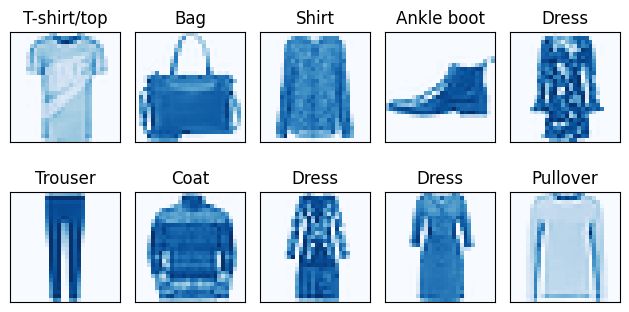

In [2]:
# load a few samples and their classes for visual inspection:
from fl_visualisation import inspect_data

inspect_data(data_train, 10)

### Unfederated Learning

As a base case for comparison, I'll first train a small network on this data in the usual straightforward fashion.

We define the network architecture here, which will be re-used later for the federated learning case. Nothing fancy: just a couple of convolution-maxpool blocks followed by a few dense layers.

In [36]:
from torch import nn
import torch.nn.functional as F
from torchsummary import summary

class SimpleCNN(nn.Module):
    def __init__(self, 
                 img_dims: tuple[int,int] = DATA_IMG_DIMS,
                 num_classes: int = DATA_NUM_CLASSES):
        super().__init__()

        self.img_dims = img_dims
        self.num_classes = num_classes
        
        # we'll do two conv layers, each followed by a 2x2 max pool:
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 12, 5)
        # pool again here

        # then reshape and feed into a stack of dense layers
        self.flatten = nn.Flatten()

        # calculate the number of units in the flattened feature vector,
        # based on the size and stride of our convolutions:
        # (is there an idiomatic way to do this in torch?)
        feature_dims = [((dim - 4) // 2 - 4) // 2  for dim in self.img_dims]
        num_spatial_units = np.prod(feature_dims) * 12
        self.dense1 = nn.Linear(num_spatial_units, 64)
        self.dense2 = nn.Linear(64, 32)
        self.dense3 = nn.Linear(32, self.num_classes)

    def forward(self, x):
        
        # add a channel dimension of size 1 (for grayscale data input):
        x = x[:,None,:,:]

        # conv, pool, relu:
        x = F.relu(self.pool(self.conv1(x)))
        x = F.relu(self.pool(self.conv2(x)))

        # unroll into vector:
        x = self.flatten(x)
        
        # linear, relu:
        x = F.relu(self.dense1(x))
        x = F.relu(self.dense2(x))
        
        # output logits:
        x = self.dense3(x)
        return x

# print a summary of the network layers and parameter counts:
summary(SimpleCNN(), DATA_IMG_DIMS)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 24, 24]             156
         MaxPool2d-2            [-1, 6, 12, 12]               0
            Conv2d-3             [-1, 12, 8, 8]           1,812
         MaxPool2d-4             [-1, 12, 4, 4]               0
           Flatten-5                  [-1, 192]               0
            Linear-6                   [-1, 64]          12,352
            Linear-7                   [-1, 32]           2,080
            Linear-8                   [-1, 10]             330
Total params: 16,730
Trainable params: 16,730
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.06
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


In [40]:
# some training hyperparameters:
BATCH_SIZE = 64
NUM_EPOCHS = 3
INITIAL_LEARNING_RATE = 1e-1

DEVICE = 'cpu'
# when I left my last job they took away my GPU laptop :(

In [41]:
#### initialising and training baseline (un-federated) network

from torch.utils.data import DataLoader
from torch import optim

import time

from fl_data_handling import num_correct, get_val_metrics
from fl_monitoring import ProgressReporter

# instantiate model:
net = SimpleCNN().to(DEVICE)

# categorical crossentropy for multiclass classification:
loss_func = nn.CrossEntropyLoss()

# I'm using vanilla SGD without momentum, because this simplifies
# the federated learning setting we'll get to later
opt = optim.SGD(net.parameters(), lr=INITIAL_LEARNING_RATE)

# scheduling learning rate decay is straightforward though:
scheduler = optim.lr_scheduler.LambdaLR(opt, lambda e: (1/3)**e)

# set up data loaders:
train_loader = DataLoader(data_train, batch_size = BATCH_SIZE, shuffle=True)
val_loader = DataLoader(data_val, batch_size = BATCH_SIZE, shuffle=True)
val_iter = iter(val_loader)

# and this is just a class that tracks loss/accuracy and prints them nicely:
progress = ProgressReporter(steps_per_epoch = len(train_loader),
                            num_epochs = NUM_EPOCHS,
                            time_interval = 0.5)

#### begin training!

for e in range(NUM_EPOCHS):
    for data in train_loader:
        batch_x, batch_y = data
        
        # forward pass:
        opt.zero_grad()
        batch_out = net(batch_x)
        batch_loss = loss_func(batch_out, batch_y)
        
        # propagate gradients and update model:
        batch_loss.backward()
        opt.step()

        # calculate accuracy:
        train_acc = num_correct(batch_out, batch_y) / len(batch_out)
        # validate:
        val_loss, val_acc, val_iter = get_val_metrics(net, val_loader, val_iter, loss_func)
        
        # send metrics to progress tracker:
        progress.update(batch_loss.item(), train_acc, val_loss, val_acc, 
                        lr = scheduler.get_last_lr()[0])
        # (this will also print updates at regular intervals)
        
        # end of batch
        
    # end of epoch; ratchet down the learning rate
    scheduler.step()
progress.report()

print('Finished training.')


   Epoch 3/3   -   batch 844/844    -  100.0%    
[══════════════════════════╪═════════════════════════╪═══════════════════════════]  
    train loss: 0.4257 (acc: 84.57%)           val loss: 0.4238 (acc: 84.59%)      
    time per batch: 0.0134s    current learning rate: 1e-02  


Finished.


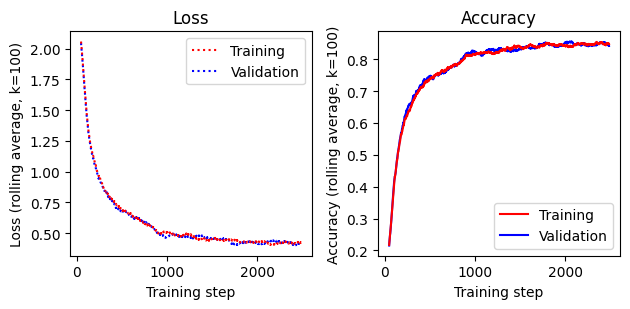

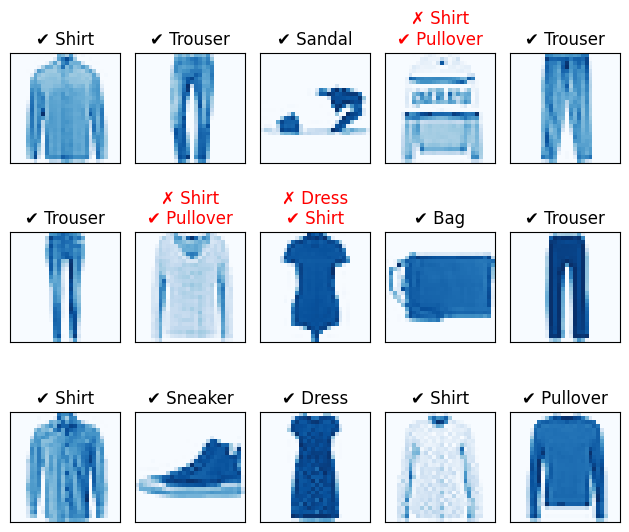

In [44]:

from fl_visualisation import inspect_model_outputs

# show the loss curve:
progress.plot_curves(rolling_window=100)

# inspect model predictions on test data:
inspect_model_outputs(net, data_test)

Pretty good. That was the easy part - now we move onto federation.

## Federated Learning

For the purpose of the exercise, we're going to pretend we don't have all the data, and instead partition it between some number of clients who each hold some fraction of it.

There will also be a central server that holds only a validation and test set, used for monitoring the performance of the global model as updates are pushed from the clients.

We'll define some global parameters for this partitioning process here:

In [28]:
# these are hyperparameters that specify the federated learning setting

NUM_CLIENTS = 5
# number of distributed client machines that will push updates to the shared model.
# the dataset is divided into this many partitions, representing private data
# held by each client.

HETEROGENEITY = 'none'
# heterogeneity of class labels across data partitions. one of 'strong', 'weak', or 'none'.
# 'none' is perfect homogeneity: stratify such that all partitions contain all class labels equally.
# 'weak' randomly skews the distribution of class labels across partitions.
# 'strong' has random skew and also drops some class labels from some partitions altogether.

# these parameters are 'in-character' with respect to the simulation.
# they initialise the central server which broadcasts them to the clients
# LEARNING_RATE = 1e-2
# BATCH_SIZE = 32
# VAL_RATIO = 0.1
# NUM_EPOCHS = 3

Then we partition the data and examine its class distribution below.



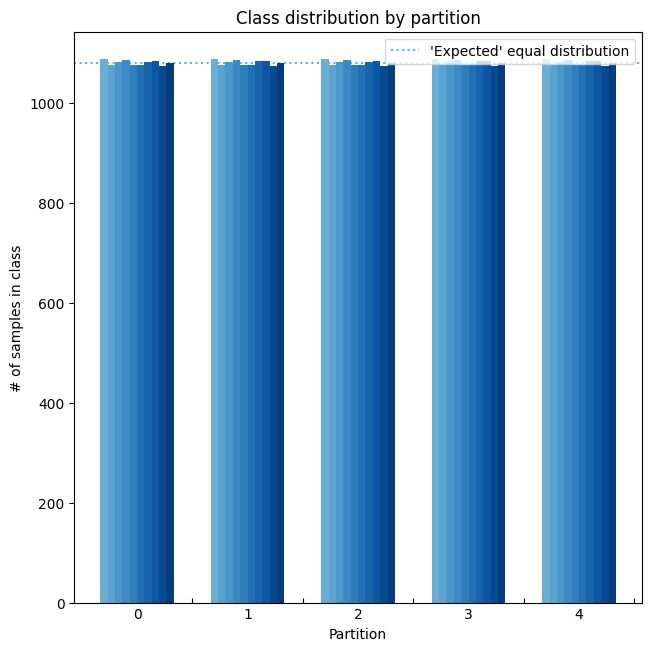

In [30]:
from fl_data_handling import partition_data
from fl_visualisation import plot_label_distribution

# partition the dataset into private chunks:
client_datasets = partition_data(data_train, 
                                 num_partitions=NUM_CLIENTS, 
                                 heterogeneity=HETEROGENEITY)

# inspect the split:
plot_label_distribution(client_datasets)

In [31]:
# one last thing before we get to federating: I found it useful to 
# define a 'checksum' method with respect to a model's parameters,
# to help debugging the process of aggregating client weight updates.

class FederatedCNN(SimpleCNN):
    """exactly the same as SimpleCNN, but with an extra checksum() utility method on top"""
    def checksum(self):
        """returns the sum of the hash of each layer's weights.
        used for testing/debugging the fed learning setting later."""
        param_sum = 0
        with torch.no_grad():
            for pname, param in self.named_parameters():
                param_sum += hash(torch.sum(param).item())
        # truncate to 6 places for brevity:
        return hash(param_sum) % int(1e6)

In [ ]:
# now we'll define the central server that holds the global model
# and the shared repository into which updates are deposited

from torch import Tensor
from torch.utils.data import Dataset

class Server:
    """central server that holds the global model and aggregates
        weight updates from clients.
    contains validation and test data used to evaluate the global
        model as it is updated, though does not include its own
        optimiser.
    all actual gradient propagation is done on client machines,
        though the server co-ordinates the training process, """
    def __init__(self, model_spec: type, # a callable nn.Module class
                 val_data: Dataset,      # server-side validation data
                 test_data: Dataset,     # server-side test data
                 repo: Repository,       # initialised Repository object (see below)
                 device: str,
                 
                 # training configuration parameters to be passed to clients:
                 initial_lr: float,
                 batch_size: int,
                 num_epochs: int,
                 val_ratio: float):

        self.val_data, self.test_data = val_data, test_data
        self.val_loader = DataLoader(self.val_data, batch_size)
        self.test_loader = DataLoader(self.test_data, batch_size)
        self.repo = repo
        self.device = device

        self.model_spec = model_spec
        self.config = {'batch_size': batch_size,
                       'val_ratio': round(val_ratio,3),
                       'num_epochs': num_epochs}
        self.initial_lr = self.current_lr = initial_lr


        # initialise the global model:
        self.global_model = self.model_spec().to(self.device)
        
        print(f'Central server initialised at: {hex(id(self))}')
        print(f' - Global model constructed from spec: {self.model_spec}:')
        print(f'     with initialisation checksum: {self.global_model.checksum()}')

        # broadcast model specification and training setup to repo:
        self.repo.model_spec = self.model_spec
        self.repo.config = self.config
        self.repo.current_lr = self.current_lr
        print(f' - Deposited model specification to repo: {self.model_spec}\n'
              f' with initial lr: {self.current_lr} and training configuration dict: {self.config}')

        self.global_epoch = 0
        self.progress = ProgressReporter # for tracking server-side metrics

    
    def broadcast_global_model(self):
        """send global model weights to repository"""
        named_params = self.global_model.named_parameters()
        self.repo.global_model_params = {name: params.detach().numpy().copy()
                                         for name, params in named_params}
        print(f'+ Central server broadcasting model params (checksum:{self.global_model.checksum()})')

    
    def aggregate_updates(self, verbose=False):
        """pull each client's published weights from repo, and take
        their weighted average to update the global model."""
        
        if verbose:
            prev_checksum = self.global_model.checksum()
            print(f'+ Aggregating updates to central model.'
                  f'  Current checksum: {prev_checksum}')
            
        # clients are weighted according to the size of their dataset,
        # i.e. those with more data contribute more to the model:
        total_samples = sum(self.repo.client_dataset_sizes.values())
        client_weightings = Tensor([self.repo.client_dataset_sizes[c] / total_samples 
                                    for c in range(self.repo.num_clients)])
        
        named_global_params = self.global_model.named_parameters()
        for pname, global_params in named_global_params:
            # for each parameter matrix, collect the respective client update dicts
            client_params_list = [Tensor(self.repo.client_updates[c][pname])
                             for c in range(self.repo.num_clients)]
            
            # stack them all up as one tensor, with first axis denoting client:
            client_params = torch.stack(client_params_list, dim=0)
            
            # then, weighted average:
            # take the parameter-wise mean of all client models
            # weighted by the size of their respective datasets
            with torch.no_grad():
                
                for dim in range(len(client_params.shape)-1):
                    # to broadcast the client weightings (a 1-d tensor)
                    # to each parameter tensor, for pointwise multiply,
                    # we need to add new dummy dimensions depending on the parameter shape
                    shaped_client_weightings = client_weightings[:,None]
                    # doing this in a loop is very ugly! 
                    # is there a better solution to this in torch?

                weighted_params = torch.mul(client_params, shaped_client_weightings)
                weighted_avg = torch.sum(weighted_params, dim=0)

                # assign to global model params of this layer:
                global_params.copy_(weighted_avg)
            
            if verbose:
                new_checksum = self.global_model.checksum()
                print(f'  Averaged layer params {pname}. '
                      f'New checksum: {new_checksum}')

                prev_checksum = new_checksum

    
    def step_learning_rate(self, formula= lambda x: x/3):
        """progress the learning rate that is sent downstream to clients for training,
            according to the specified formula.
        intended to be called at the end of every global epoch."""
        self.current_lr = formula(self.current_lr)
        self.repo.current_lr = self.current_lr
    
    def validate_model(self, test=False, verbose=False, return_str=False):
        """runs the entire validation/test set through the current 
        global model and reports loss/accuracy metrics"""
        
        if not test:
            # run on validation set
            loader = self.val_loader
            set_name = 'val'
        else:
            # run on test set
            loader = self.test_loader
            set_name = 'test'
        
        val_losses, val_accs = [], []
        for b, v_batch in enumerate(loader):
            if (verbose) and ((b+1) % 10 == 0):
                clear_output(wait=True)
                display_pretty(f'+ Validating global model... {b+1}/{len(loader)}',  raw=True)            
            val_x, val_y = v_batch
            val_out = self.global_model(val_x)
            val_losses.append(loss_func(val_out, val_y).item())
            val_accs.append(num_correct(val_out, val_y) / len(val_out))
        avg_vloss = np.mean(val_losses)
        avg_vacc = np.mean(val_accs)
        output = (f'+ Central server {set_name} loss: {avg_vloss:.4f}'
                 f'  |  accuracy: {avg_vacc:.2%}')

        if return_str:
            return output
        else:
            print(output)
            return avg_vloss, avg_vacc

I also define a `Repository` class below, intended to represent the network interface between server and clients. This isn't strictly necessary for the exercise to work, but I found it useful to demarcate the confidentiality bounds between them.

The server and the clients cannot refer to each other directly. They can both push and pull from the repo, but the repo does not contain explicit pointers to either, so the server instance has no way to access any client instance, or vice versa. 

In addition, we make sure that any data contained in the repo consists only of raw numpy arrays (detached from the torch computation graph and copied to a new memory address), so that no state variables or graph dependencies hidden inside Torch objects are being passed around.

In [ ]:
class Repository:
    """shared read/write environment between central server and clients,
        though has no methods and does not contain pointers to either.
        (just keeps tracks of how many clients have been subscribed)
    stores only raw values and numpy arrays, to ensure that no state 
        variables or graph dependencies hidden inside Torch objects are
        being passed around.
    anything contained in this class is no longer considered 'private'."""
    
    def __init__(self):
        
        self.model_spec = None # callable nn.Module class to initialise local models
        self.global_model_params = None # dict of param_names -> weight_arrays
        self.config = None # misc setup constants like validation ratio and batch size
        
        self.current_lr = None
        
        # keep track of how many clients are subscribed:
        self.num_clients = 0

        # clients will not share their individual per-class distributions
        # but they will share the total size of their datasets:
        # (so that the server can weight their updates proportionally)
        self.client_dataset_sizes = {}
        
        # and their local model gradients/parameters at each update:
        self.client_updates = {} # dict of (client_id) -> (gradients) mappings
        
        print(f'Shared repository initialised at: {hex(id(self))}')
    

In [ ]:
# next, define the client agents that hold their private data
# and keep local instances of the central server's global model
from torch.utils.data import random_split
import asyncio
# reload(fl_visualisation)
# from fl_visualisation import ProgressReporter
from fl_preprocessing import get_class_distribution


class Client:
    """distributed client machine which holds a private data partition.
    cannot expose its data, but is allowed to share model weight updates."""
    def __init__(self, 
                 data: Dataset, # local partitioned data
                 client_id: int,  # unique integer to identify this client
                 repo: Repository,  # repository object to send/receive updates from
                 val_ratio: float = 0.3, # how much local data to keep for validation
                 device: str = 'cpu',
                 verbose: bool = True):
        self.data = data 
        self.id = client_id # just a unique integer to identify this client by
        self.repo = repo
        self.repo.num_clients += 1
        self.device = device

        # initialise local model:
        self.model = repo.model_spec().to(self.device)
        if verbose:
            print(f'+{self} initialised at: {hex(id(self))}')
            print(f'  Local model constructed with initial checksum: {self.model.checksum()}')

        # set up local data split and associated dataloaders:
        self.data_train, self.data_val = random_split(self.data, [1-VAL_RATIO, VAL_RATIO])

        self.train_loader = DataLoader(self.data_train, shuffle=True, batch_size=BATCH_SIZE)
        self.val_loader = DataLoader(self.data_val, shuffle=True, batch_size=BATCH_SIZE)
        self.train_iter, self.val_iter = iter(self.train_loader), iter(self.val_loader)

        # transmit our training set size to repo:
        self.repo.client_dataset_sizes[self.id] = len(self.data_train)
        print(f'  Reporting local training set size ({len(self.data_train)}) to repo\n')
        
        # we need the distribution of the local dataset's labels
        # so we can weight the losses appropriately
        self.class_distribution = get_class_distribution(self.data_train)
        self.class_weights = [0 for i in range(len(self.data.classes))]
        for cls, frac in self.class_distribution.items():
            self.class_weights[cls] = 1-frac

        self.current_lr = self.repo.current_lr
        self.loss_func = nn.CrossEntropyLoss(weight=Tensor(self.class_weights))
        self.opt = optim.SGD(self.model.parameters(), lr=self.current_lr)

        # for tracking local training progress:
        self.local_epoch = 0
        self.progress = ProgressReporter(steps_per_epoch = len(self.train_loader), 
                                         num_epochs=self.repo.config['num_epochs'],
                                         time_interval=0.5)
        
    def __repr__(self):
        return f'Client #{self.id}'
    
    def update_local_model(self, verbose=False):
        named_global_params = self.repo.global_model_params
        named_local_params = self.model.named_parameters()
        prev_checksum = self.model.checksum()
        
        with torch.no_grad():
            for name, local_params in named_local_params:
                global_params = named_global_params[name].copy()
                # we copy the globalparams to ensure that this model's local weights
                # are stored separately to the weights of every other model
                assert isinstance(global_params, np.ndarray)
                local_params.copy_(Tensor(global_params))

        if verbose:
            print(f'+ {self} local model (checksum:{prev_checksum}) synced with global parameters (new checksum:{self.model.checksum()})')

    
    def transmit_params(self, 
                        gradients:bool=False, # send layer gradients if True, else send weights
                        verbose=False):
        client_params = {}
        # iterate through local parameters and retrieve parameters/gradients:
        named_local_params = self.model.named_parameters()        
        for pname, params in named_local_params:
            if gradients:
                client_params[pname] = params.grad.detach().numpy().copy()
            else:
                client_params[pname] = params.detach().numpy().copy()
            # the .copy() method is required to ensure that the new array
            # is stored separately to the original

        # copy to repository:
        if verbose:
            param_type = 'gradients' if gradients else 'weights'        
            print(f'+ {self} transmitting model {param_type} (checksum: {self.model.checksum()}) to repo')
        self.repo.client_updates[self.id] = {pname:params for pname,params in client_params.items()}

    def update_learning_rate(self):
        """explicitly sets the learning rate of this client's SGD optimiser.
        needs to be done manually since it is the central server that
        co-ordinates learning rate scheduling."""
        self.current_lr = self.repo.current_lr
        for group in self.opt.param_groups:
            group['lr'] = self.current_lr
        
    async def train_step(self, 
                   batch: tuple[Tensor, Tensor] = None,
                   validate: bool = True,
                   transmit_weights: bool = False,
                   transmit_gradients: bool = False,
                   verbose: bool = False):
        """train local model for a single step on current dataloader.
        by default will draw a batch from the current train iterator,
            but can optionally be given a specific batch to feed through
            (e.g. when this method is called as part of a training loop)"""
        if batch is None:
            try:
                batch_x, batch_y = next(self.train_iter)
            except StopIteration:
                self.train_iter = iter(self.train_loader)
                batch_x, batch_y = next(self.train_iter)
        else:
            batch_x, batch_y = batch

        prev_checksum = self.model.checksum()

        self.opt.zero_grad()
        batch_out = self.model(batch_x)
        step_loss = self.loss_func(batch_out, batch_y)

        step_loss.backward()
        # now we have gradients stored in our net weights
        # we can transmit them to the repo if desired
        if transmit_gradients:
            self.transmit_params(gradients=True)

        self.opt.step()

        new_checksum = self.model.checksum()
        if verbose:
            print(f'- {self} training step: {self.step}, checksums:{prev_checksum}->{new_checksum}')
        
        # validate:
        train_acc = num_correct(batch_out, batch_y) / len(batch_out)
        val_loss, val_acc, val_iter = get_val_metrics(self.model, self.val_loader, 
                                                      self.val_iter, self.loss_func)
        # record inside progress tracker:
        self.progress.update(step_loss.item(), train_acc, val_loss, val_acc, lr=self.current_lr)

        # now we've updated local weights
        # and can transmit thoes to repo if desired
        if transmit_weights:
            self.transmit_params(gradients=False)

        if verbose:
            print(f'  training loss: {self.progress.train_losses[-1]:.6f}')
            print(f'       accuracy: {self.progress.train_accs[-1]:.2%}')
            print(f'  updated local model with optimiser, new checksum: {self.model.checksum()}\n') 

    async def train_epoch(self, 
                    num_epochs:  int=1, 
                    print_steps: int=50,
                    verbose:    bool=False,
                    show_progress = True):

        self.progress.finished_epoch = False
        for e in range(num_epochs):
            for batch in self.train_loader:
                await self.train_step(batch)
                # short amount of sleep required to make models train simultaneously:
                await asyncio.sleep(0.00001)
            self.local_epoch += 1
            self.progress.finished_epoch = True
        

In [ ]:
# first, we set up the repo:
repo = Repository()

# then the server, which sends the model specification to the repo:
server = Server(SimpleCNN, data_val, data_test, repo)
# as well as the initial model parameters:
server.broadcast_model_params()

for pname, params in server.global_model.named_parameters():
    print(f'{pname:>15} mean: {torch.mean(params):+.5f}')

In [ ]:
# clients instantiate their own local models from the spec:
clients = [Client(client_datasets[i], i, repo, verbose=True) for i in range(NUM_CLIENTS)]

# and pull the global model's parameters so they all match:
for client in clients:
    client.update_local_model(verbose=True)

In [ ]:
# now we'll try training the clients for one epoch before federating.
# this works perfectly fine if we run them sequentially,
# but I've made them all train simultaneously because it's more fun:

import asyncio
reload(visualisation)
from monitoring import JointProgressReporter

agg_reporter = JointProgressReporter([client.progress for client in clients])

for e in range(1):
    # then just wrap them all in an async routine and train:
    async def train_all_clients():
        tasks = [client.train_epoch(show_progress=False) for client in clients]
        await asyncio.gather(*tasks)
    await train_all_clients()

    # final report after training is complete:
    agg_reporter.report()


In [ ]:
# get current global parameters, compare to initialised ones:
for pname, params in server.global_model.named_parameters():
    print(f'{pname:>15} mean: {torch.mean(params):+.5f}')

# then the models send their local updates to the repo:
for client in clients:
    client.transmit_params(verbose=True)

In [ ]:
# the server aggregates them into the global model
# according to our chosen strategy:
server.aggregate_updates(verbose=True)

In [ ]:
# runs the global model on the central validation data:
server.validate_model()

# then broadcasts the new global weights:
server.broadcast_model_params()

In [ ]:
# which the clients pick up to replace their existing local models:
for client in clients:
    client.update_local_model(verbose=True)

In [ ]:
# let's run the whole thing now
# with a fresh server/client setup:

# these parameters are 'in-character' with respect to the simulation.
# they initialise the central server which broadcasts them to the clients
LEARNING_RATE = 1e-1
BATCH_SIZE = 32
VAL_RATIO = 0.1
NUM_EPOCHS = 5

repo = Repository()

# then the server, which sends the model specification to the repo:
server = Server(SimpleCNN, data_val, data_test, repo)
# as well as the initial model parameters:
server.broadcast_model_params()

clients = [Client(client_datasets[i], i, repo, verbose=True) for i in range(NUM_CLIENTS)]
[client.update_local_model() for client in clients]

agg_reporter = ProgressAggregator([client.progress for client in clients])

for e in range(NUM_EPOCHS):
    # then just wrap them all in an async routine and train:
    async def train_all_clients():
        tasks = [client.train_epoch(show_progress=False) for client in clients]
        await asyncio.gather(*tasks)
    await train_all_clients()

    # report at end of epoch
    agg_reporter.report()

    ### federation step:
    
    # transmit local params, aggregate to global model:
    [client.transmit_params() for client in clients]
    server.aggregate_updates()

    # validate on local data:
    val_stats = server.validate_model(return_str=True)
    agg_reporter.messages.append(f'Epoch {e+1}  (lr:{repo.current_lr:.0e}) \n{val_stats}')

    if (e+1) < NUM_EPOCHS:
        # broadcast the new model params and learning rate: and pull the new weights:
        server.broadcast_model_params()
        server.step_learning_rate()
    
        # clients update to match:
        [client.update_local_model() for client in clients]
        [client.update_learning_rate() for client in clients]
    
        # then train next epoch and repeat
    else:
        # at final epoch, evaluate model on unseen test data:
        print(f'\n  Final evaluation:')
        final_eval = server.validate_model(test=True)
        inspect_model_outputs(server.global_model, server.test_data)

In [ ]:
# next: plot loss curve with servers in dotted lines and central server as thick line

... ### here

In [ ]:
# here: fedprox

# fedprox still uses weighted averaging at the aggregation step,
# but differs in adding a regularisation term to the weight of the client models.

# I implement that here by subclassing Client to overwrite the train step:
class FedProxClient(Client):
    async def train_step(self, 
                   prox_term: float,
                   batch: tuple[Tensor, Tensor],
                   validate: bool = True,
                   transmit_weights: bool = False,
                   transmit_gradients: bool = False,
                   verbose: bool = False):
        """as Client.train_step, except that the loss additionally
        includes a regularisation term proportional to the distance
        between the client weights and those of the global model"""
        
        ### as before: run model on batch and compute loss
        batch_x, batch_y = batch
        self.opt.zero_grad()
        batch_out = self.model(batch_x)

        # only now we call this 'client loss' and it is 
        # only one half of the loss equation
        client_loss = self.loss_func(batch_out, batch_y)

        # the other half is this proximity loss term
        # that must iterate through the latest global model's parameters
        # and compare them to this client's current parameters
        layer_distances = []
        for pname, local_params in self.model.named_parameters():
            global_params = Tensor(self.repo.global_model_params[pname])
            distance = global_params - local_params
            # flatten each layer's parameters into a single, very long vector:
            layer_distances.append(torch.flatten(distance))
        distance_vector = torch.concatenate(layer_distances)
        
        # the proximity loss term is the L2 norm of this distance vector:
        prox_loss = torch.linalg.vector_norm(distance_vector, p=2)
        # notably, this is equivalent to MSE between the local and global weights,
        # and could be considered a special kind of weight decay regularisation.

        
        # the total loss is a weighting of the two individual terms,
        # controlled by the 'prox_term' arg to this method:
        weighted_prox_loss = prox_term * prox_loss
        total_loss = client_loss + weighted_prox_loss
        total_loss.backward()

        #### the rest is all the same
        self.opt.step()

        # validate:
        if validate:
            train_acc = num_correct(batch_out, batch_y) / len(batch_out)
            val_loss, val_acc, val_iter = get_val_metrics(self.model, self.val_loader, 
                                                          self.val_iter, self.loss_func)
            # record inside progress tracker:
            self.progress.update(client_loss.item(), train_acc, val_loss, val_acc, 
                                 prox_loss = weighted_prox_loss, lr=self.current_lr)

### Practical considerations not implemented

#### Secure aggregation
- My implementation 

- As I understand it this is typically done by homomorphic encryption, stochastic masking, or differentially-private parameter perturbations. 

#### Client co-ordination & robustness
- I understand that in practice it is common to select random subsets of the clients for training and local validation.
- I don't do that here (we train on all clients each round) but it would be a straightforward modification
- In either case we would also want to consider network failure and the protocol's robustness against clients dropping out during the training process
- also of relevance are theoretical malicious clients that could deliberately poison the model by supplying adversarial weight updates.

#### Optimisation hyperparameters
- I have deliberately chosen a stateless optimiser (vanilla SGD) to simplify the aggregation step
- The inclusion of momentum or per-parameter learning rates (e.g. with RMSProp or Adam) presumably follows similar logic to the layer-wise averaging of weight parameters themselves, but I have not researched this in detail
- Learning rate scheduling would be reasonably simple to add on, although involves some compromises for unbalanced dataset sizes

#### Regularisation
- This toy model works fine without any regularisation because it's so small
- For larger models, weight decay can probably be handled entirely during client-side training
- i.e. no need for communication with server or explicit aggregation approach
- Probably helps a lot in practice, my intuition is that it would help client models all converge in the same 'direction'
- Likely similar story for dropout; although might be more unstable given stochasticity??

#### Batch normalisation
- Similar to regularisation, not needed for this model on this dataset
- But probably very important in practice given domain gap between heterogeneous client datasets
- Aggregating BN population statistics for inference presumably works fine by (weighted) averaging between client models, but I have not researched this
- Possible confidentiality concerns too, but batch-level population statistics seem differentially private to me

In [ ]:
# compare to Flower implementation:

